In [ ]:
import folium
from folium.plugins import HeatMap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import re
import string
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sodapy import Socrata
import xgboost as xgb


# Predicting if an Animal will be re-homed in <30 Days Using Government Data.

Below is a mini-project I started that attempts to predict if an animal taken in from Austin animal shelter will be re-homed in 30 days. I did this to better understand Tree + Ensemble methods in Sklearn.

- This project was inspired by a [mini-course on decision trees from AWS](https://github.com/aws-samples/aws-machine-learning-university-dte).
- Raw data is taken from [The City of Austin Texas's government data page](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm).

This project is ongoing, please excuse any grammatical mistakes or unfinished parts!

### Ongoing goals to add (As of 4/13/22):

1. Pull data via SODA API or create local SQL server to perform pulls. Problematic as SODA API won't let me pull "max rows."
2. Attempt other ensemble methods. Ideally ADA boosted trees and NN (when I master this).
3. Finish with fine tuning and assessing over test set.
4. Create final table of results + takeaways.
5. Expand on EDA, clean up as part of presentation to Austin Shelter team.
6. **NEW 7/2022** Clean up coding syntax


## Data Intake + Prep

Cleaning is one of the most important aspects of any project. Below I attempt to:

1. Pull in data via API, create datasets
2. Find missing or bad data, these rows could skew our analysis, especially if features contain many missing values or behave in unexpected ways.
3. Apply cleaning rules to data.
4. Merged datasets to have a beginning endline dataset to run EDA over.

---


### 1. Grab Data


In [ ]:
# Define way to create raw data from API
def data_feeder(df):
    a = pd.DataFrame.from_records(df)
    a.columns = a.iloc[0]
    a = a[1:]
    # Annoying feature of from_records is that it replaces NaN with ''
    a = a.replace('', np.nan)
    return a


In [ ]:
# Call API to get Data
client = Socrata("data.austintexas.gov", 'HwnJIRk3Ph7NqQ0cPB0MOPkTF')
intake = client.get("wter-evkm", limit=99999999, content_type='csv')
outcome = client.get("9t4d-g238", limit=99999999, content_type='csv')

# Make data
intake_df = data_feeder(intake)
outcome_df = data_feeder(outcome)
geocoded_df = pd.read_csv('geocoded_locations.csv')


In [ ]:
a = pd.DataFrame.from_records(outcome)
a.columns = a.iloc[0]
a = a[1:]
# Annoying feature of from_records is that it replaces NaN with ''
a = a.replace('', np.nan)


### 2. Find bad/missing data:

Here I am looking for any columns that might be problematic to our analysis (many missing values, extreme values, or nonsensical values that require more digging).

I want to automate this, if we find a small amount of NaN's we should be fine to just drop them. If these NaN become a larger issues (lets say > %2) we need to pause and manually inspect what is going on.

It should be noted that this notebook is a little backwards, I was able to do a mix of EDA and bad data cleanup in unison but for clarity to an external audience I just separate the two. This means I found odd relationships later into EDA but came back up here to insert cleaning rules.


In [ ]:
# Let's make a function to output what's missing
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()
    drop_list = percent_nan[(percent_nan < 2) & percent_nan != 0]
    if percent_nan.shape[0] == 0:
        print("No NA values, consider checking the data")
    else:
        print(percent_nan)
    return drop_list.index.to_list()


intake_drop = percent_missing(intake_df)
outcome_drop = percent_missing(outcome_df)


In [ ]:
# Clean Data
def lower_case_col(columns):
    return columns.replace(" ", "_").lower()


def sort_for_merge(var, name):
    return var.sort_values(by=[name + '_datetime']).groupby(['animal_id']).cumcount()+1


def clean_up(dataframe, droplist, name):
    return (dataframe
            .rename(columns=lower_case_col)
            .assign(name_avail=np.where(dataframe.name.isna(), 0, 1),
                    datetime=pd.to_datetime(dataframe.datetime),
                    month=lambda x: x.datetime.dt.month
                    )
            .dropna(subset=droplist)
            .rename(columns={'datetime': name+'_datetime'})
            .drop(['name'], axis=1)

            )


In [ ]:
# Apply to Data
intake_df_clean = clean_up(intake_df, intake_drop, 'intake')
outcome_df_clean = clean_up(outcome_df, outcome_drop, 'outcome')


### 3. Merge Intake & Outcome Data:

Now merge the semi-cleaned data together so I can continue with feature engineering and EDA. To do this I first create merging variables.

The same animal can show up multiple times, however their intake and subsequent outcome are always in order. For instance if dog A has been intaken 5 times in our data, then they'll be in the outcome 5 times, if not the animal is still waiting for an outcome. I can't merge these multiple instances on ID and date as an animal will come in a different date it leaves, but I can sort on date in both dataframes and create a unique merge variable instead.


In [ ]:
def sort_for_merge(var):
    var['merge_counter'] = var.sort_values(
        by=([col for col in var.columns if 'datetime' in col])).groupby(['animal_id']).cumcount()+1


sort_for_merge(intake_df_clean)
sort_for_merge(outcome_df_clean)

# Now merge
merged_df = intake_df_clean.merge(outcome_df_clean[[
    'outcome_type',
    'animal_id',
    'outcome_datetime',
    'merge_counter']],
    on=['animal_id',
        'merge_counter'],
    how='outer',
    indicator=True)

# Okay most merged!
print(merged_df._merge.value_counts())

# lets just keep in the inner product
merged_df = merged_df[merged_df._merge == 'both']


## EDA + Feature Engineering

This step attempts to combine multiple aspects of any data science project together:

1. Identify worthwhile features to use and determine what features to create.
2. Create new features. Many of the raw features given are not ready to run EDA over. I need to still fix and create features.
3. Perform EDA and identify any issues or interesting relationships.
4. Drop observations or clean features of interest.
5. Specify features types and transform as needed

Feature Engineering is an ongoing process however, so what is listed above is only a portion of what I do on this project. Moreover, this process is an overarching step of this project. Under the hood and behind the curtains lies hundreds of lines of depreciated code, useless features, and other analysis not included. Later on I will continue feature engineering by dummying our variables (after EDA).

---


### 1.Identify

First I need to think of what features in the intake data could potentially predict if an animal will be rehomed, I don't want to throw the whole kitchen sink of features in potentially adding noise to my analysis. Second, I need to understand and define "rehomed." What is the key performance metric I should use?

Much of this "Identify" comes during EDA or via simple inspection of my data. I already know by looking that intake Age is important, breed, and time of adoption.


### 2. Create

After Identifying what I could use in the intake data, I need to create additional features and retool existing ones to my liking. Some potential ideas I saw:

1. Seasonality might matter, having an animal come in near Christmas might spur higher adoptions.
2. Age needs to be standard across animals, lets turn it into months.
3. How should we deal with purebred and mixed animals?


In [ ]:
# Lets make age in terms of months
def age_to_num(var):
    num, date = var.split(' ')
    num = int(num)
    if 'year' in date:
        num = num*12
    elif 'week' in date:
        num = num/4
    elif 'day' in date:
        num = num/30
    else:
        num
    if num < 0:
        num = np.nan
    return(num)

#Add more
merged_df = (
    merged_df
    # Few more X's
    .assign(age=merged_df.age_upon_intake.apply(age_to_num),
            # Let's make a "purebred" variable for dogs. This should only really matter for dogs, as for cats "shorthair mix" & "shorthair" for a cat are identical. Moreover, what is the difference between a "cow" and "cow mix?"
            purebred=np.where((merged_df.animal_type == "Dog") & ~(
                merged_df.breed.str.contains("Mix|/")), 1, 0),
            days=(merged_df.outcome_datetime -
                  merged_df.intake_datetime) / np.timedelta64(1, 'D'),
            )
    # Start on Y's
    .assign(adopted=np.where(merged_df.outcome_type.str.contains('Adopt'), 1, 0),
            rehomed=np.where(merged_df.outcome_type.str.contains(
                'Adopt|Rto|Return to Owner'), 1, 0),
            rehomed_in_30_days=lambda x: np.where(
            (x.rehomed == 1) & (x.days <= 30), 1, 0)
            )
)


In [ ]:
# First SnowballStemmer

# specify stop_words: words that can be ignored when simplifying our strings
stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')


def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()

    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)

    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)

    # remove extra white space
    text = re.sub('\s+', ' ', text)

    return text


def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)

    return text


def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)


# Clean the text features
for c in ['breed', 'color', 'found_location', 'intake_condition']:
    print('Text cleaning: ', c)
    merged_df[c] = [cleanSentence(
        item, stop_words, stemmer) for item in merged_df[c].values]
    merged_df[c] = [cleanSentence(item, stop_words, stemmer)
                    for item in merged_df[c].values]


In [ ]:
#Clean up our data
merged_df=(merged_df
.astype({'animal_type':'category',
'month':'category',
'sex_upon_intake':'category',
'intake_condition':'category',
'intake_type':'category',
'found_location':'string',
'breed': 'category',
'color': 'category',
'breed':'category',
'purebred': 'int',
'name_avail':'int'})
)

In [111]:
def create_model(x = '', y = '' ,feats = [], model = '', tree = 0):
    """
    Creates a pipeline and fits model from Sklearn

    inputs
    ------------
    x: obs and covariates used in training
    y: outcome of obs in training
    feats: features you'd like to feed into the pipeline
    model: sklearn model you want to run
    tree: boolean, tree models use a different pipe (don't standardize the values)
    """
    #Break up features by dtype:
    num_feats = x[feats].select_dtypes('number').columns.to_list()
    cat_feats = x[feats].select_dtypes('category').columns.to_list()
    str_feats = x[feats].select_dtypes('string').columns.to_list()

    #Define Pipes
    if tree == 0:
        num_pipe = Pipeline([
            ('num_imputer', SimpleImputer(strategy='mean')),
            ('standardize', StandardScaler())
        ])
    else:
        num_pipe = Pipeline([
            ('num_imputer', SimpleImputer(strategy='mean')),
            ('standardize', StandardScaler())
        ])
        
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant',
                                    fill_value='missing')),
        ('coder', OneHotEncoder(handle_unknown='ignore'))
    ])
    str_pipe = Pipeline([
        ('str', CountVectorizer(binary=True, max_features=150))
    ])

    if str_feats == []:
        #Create prep pipe depending on the feats you fed in
        prep = ColumnTransformer([
        ('num', num_pipe, num_feats),
        ('cat', cat_pipe, cat_feats),
        ])
    else:
        prep = ColumnTransformer([
        ('num', num_pipe, num_feats),
        ('cat', cat_pipe, cat_feats),
        ('str', str_pipe, str_feats[0])
        ])

    final = Pipeline([
        ("prep", prep),
        ("model", model)
    ])


    #fit
    final.fit(x, y)
    return final




def create_fitted_datasets(x_data, y_data, x_feat,model_run_dict):
    fitted_models = {}

    #Train all of our models
    for model_name, model_run in model_run_dict.items():
        if 'tree' in model_name:
            tree_val = 1 
        else:
            tree_val = 0
        fitted_models[model_name] = create_model(x = x_data, y = y_data, feats=x_feat, model = model_run, tree=tree_val)
        print(model_name, " Done!")   



    val_df = pd.DataFrame()

    #Predict on val data and create DF to compare
    for index_val, model_name in enumerate(fitted_models):
        predict_val = fitted_models[model_name].predict(X_val)
        predict_prob_val = fitted_models[model_name].predict_proba(X_val)[:,1]
        report = classification_report(y_val, predict_val,output_dict=True)
        report['1']['roc_auc_score'] = roc_auc_score(y_val, predict_prob_val)
        report['1']['accuracy'] = report['accuracy']
        report['1']['model'] = model_name
        #df = df.append(pd.DataFrame(report['1'], index=[i]))
        val_df = pd.concat([val_df, pd.DataFrame(report['1'], index=[index_val])])

    return fitted_models, val_df



def model_importance(model):
    """
    Creates a pandas dataframe with coefficient value & name

    inputs
    ------------
    model: Sklearn specificed model (Made in create_model)
    """
    #Grab Coef
    if 'XGB' in str(type(model.named_steps['model'])):
        coef = list(model.named_steps['model'].get_booster().get_fscore().values())
        print(1)
    elif 'log' in str(type(model.named_steps['model'])):
        coef = model.named_steps['model'].coef_.flatten().round(3)
    else:
        coef = model.named_steps['model'].feature_importances_.round(3)




    b = list(model['prep'].transformers_[0][2])
    cat_features = list(model['prep'].transformers_[1][1]['coder'].get_feature_names_out())
    try:
        str_features = list(model['prep'].transformers_[2][1].get_feature_names_out())
    except:
        str_features=[]
    
    all_featues = b + cat_features + str_features

    test = ['x' + str(count) + '_' for count in range(len(x))]

    rename_coef = dict(zip(test, [s+'_' for s in cat_feats+str_feats]))

    importance = (pd
    .DataFrame(list(zip(coef,all_featues)))
    .replace(rename_coef, regex=True)
    .rename(columns={0:'val', 1:'feature'})
    .sort_values('val', ascending=False)
    )

    return importance

In [113]:
num_feats = ['age', 'merge_counter', 'name_avail', 'purebred']
cat_feats = ['animal_type', 'month','sex_upon_intake', 'intake_condition', 'color', 'breed']
str_feats = ['found_location']

x = num_feats + cat_feats + str_feats
x_simple = num_feats + ['animal_type', 'month','sex_upon_intake', 'intake_condition', 'breed']
y = 'rehomed_in_30_days'

#Specify Naive Models
model_run_dict = {
    'log': LogisticRegression(max_iter=10e10, random_state=1),
    'ada_tree': AdaBoostClassifier(random_state=1),
    'xgb_tree': xgb.XGBClassifier(random_state=1)
}


In [ ]:
val_dict = {}
fitted_dict = {}
ticker = 0 

for x_data in [x,x_simple]:
    for y_data in ['rehomed_in_30_days', 'rehomed', 'adopted']:

        train_data, test_data = train_test_split(
        merged_df, test_size=0.2, shuffle=True, random_state=1)

        # From the test data further split into validation (we use throughout process) & test (use only at end)
        val_data, test_data = train_test_split(
        test_data, test_size=0.5, shuffle=True, random_state=1)
        outcome_0_train = train_data[train_data[y_data] == 0]
        outcome_1_train = train_data[train_data[y_data] == 1]
        outcome_0_test = test_data[test_data[y_data] == 0]
        outcome_1_test = test_data[test_data[y_data] == 1]
        upsampled_class_1_no = outcome_1_train.sample(
        n=len(outcome_0_train), replace=True, random_state=1)
        train_data = pd.concat([outcome_0_train, upsampled_class_1_no])
        train_data = train_data.sample(frac=1).reset_index(drop=True)

        # Get train data to train the network
        X_train = train_data[x_data]
        y_train = train_data[y_data]

        # Get validation data to validate the network
        X_val = val_data[x_data]
        y_val = val_data[y_data]

        # Get test data to test the network
        X_test = test_data[x_data]
        y_test = test_data[y_data]

        fitted_models, val_df =  create_fitted_datasets(X_train, y_train, x_data, model_run_dict=model_run_dict)
        val_dict[ticker] = val_df
        fitted_dict[ticker] = fitted_models
        ticker += 1
        print(x_data, y_data, 'done!')
        print('----'*10)

In [ ]:
ticker = 0
name_dict = {}
final_df = pd.DataFrame()
for x_data in [x,x_simple]:
    for y_data in ['rehomed_in_30_days', 'rehomed', 'adopted']:
        str_x = ''
        str_y = ''
        
        if set(x_data) == set(x):
            str_x = "x"
            name_dict[ticker] = str_x
        else:
            str_x = "x_simp"
            name_dict[ticker] = str_x


        if y_data == 'rehomed_in_30_days':
            str_y = "y_30"
            name_dict[ticker] = name_dict[ticker] +'_'+ str_y

        elif y_data == 'rehomed':
            str_y = "y_reh"
            name_dict[ticker] = name_dict[ticker] +'_'+ str_y
        else:
            str_y = "y_ado"
            name_dict[ticker] = name_dict[ticker] +'_'+ str_y

        
        val_dict[ticker]['x'] = str_x 
        val_dict[ticker]['y'] = str_y 
        final_df = pd.concat([final_df, val_dict[ticker]])
        ticker += 1

name_dict



In [ ]:
final_df.sort_values(by=['roc_auc_score','model','x','y'])

In [ ]:
fitted_dict[0]['xgb_tree']

1
1
1
1
1
1


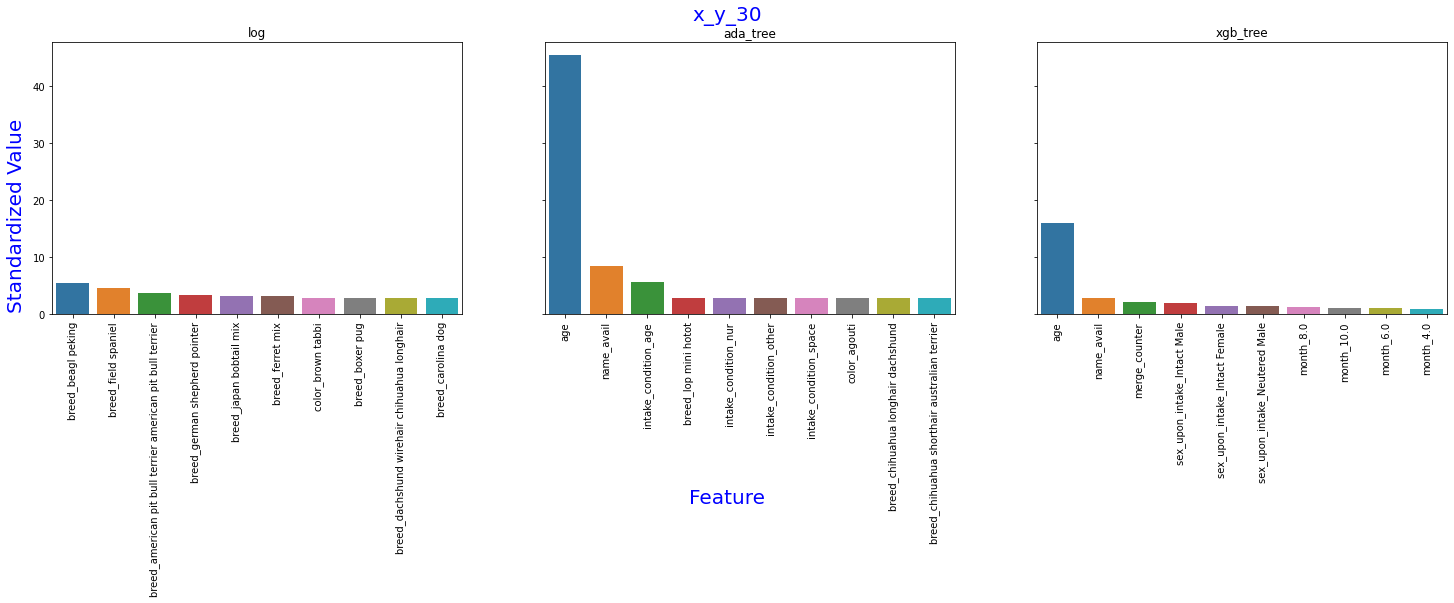

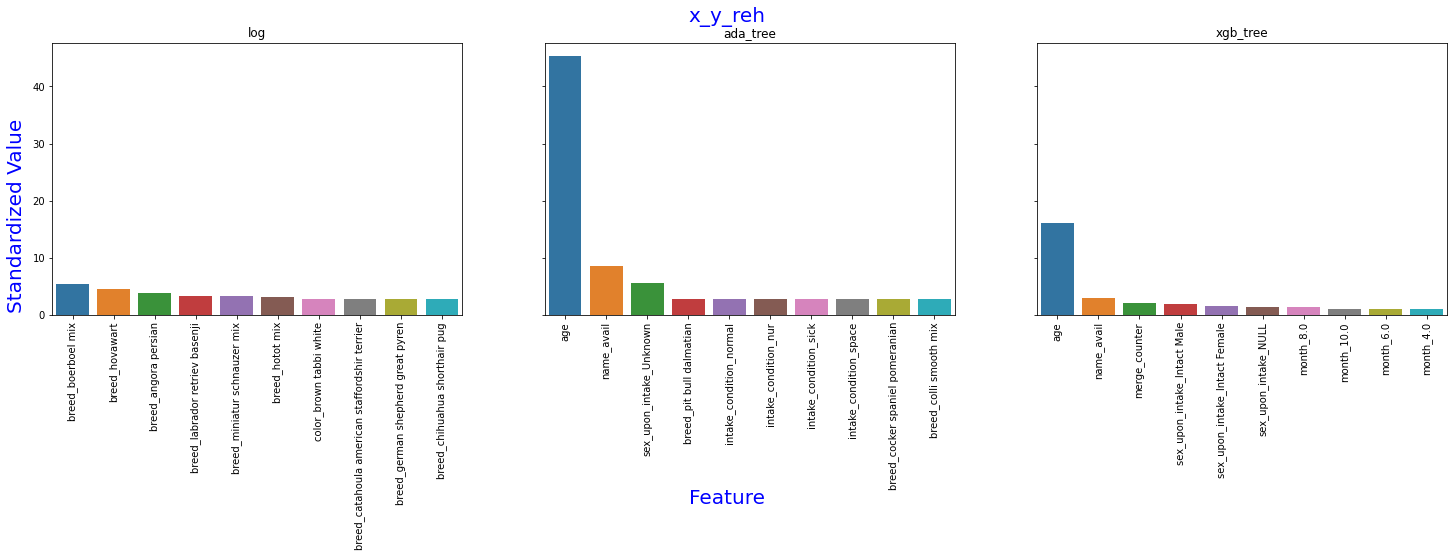

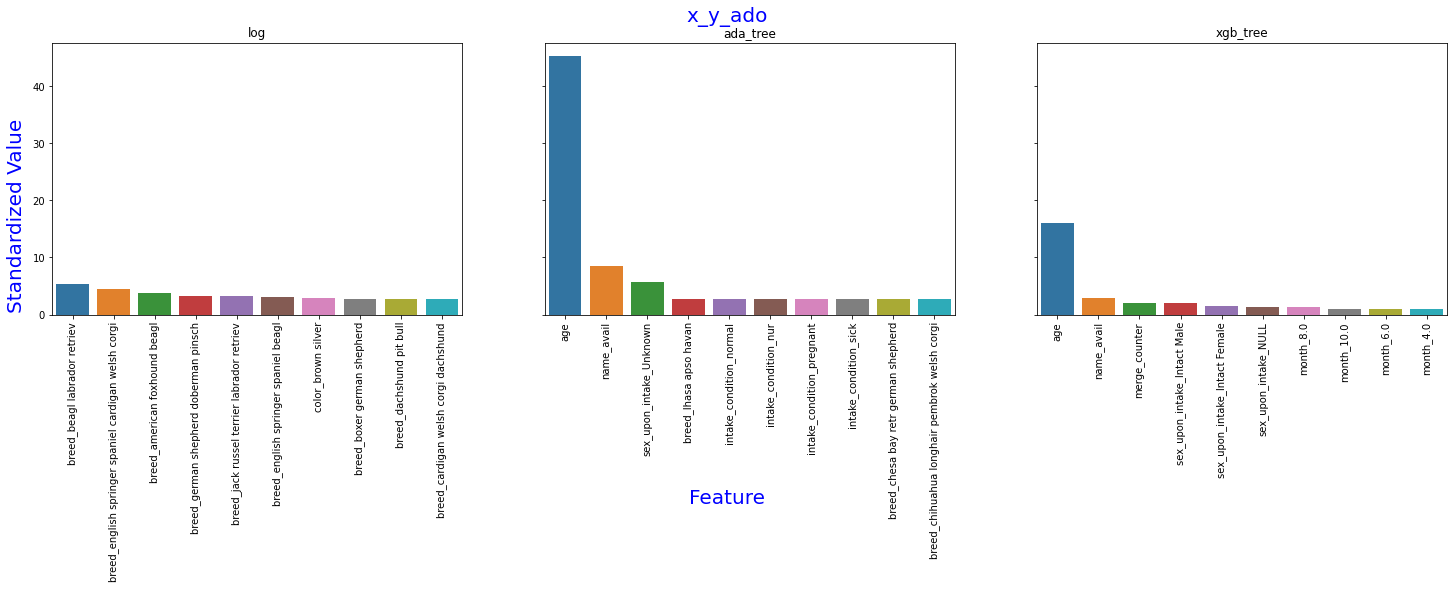

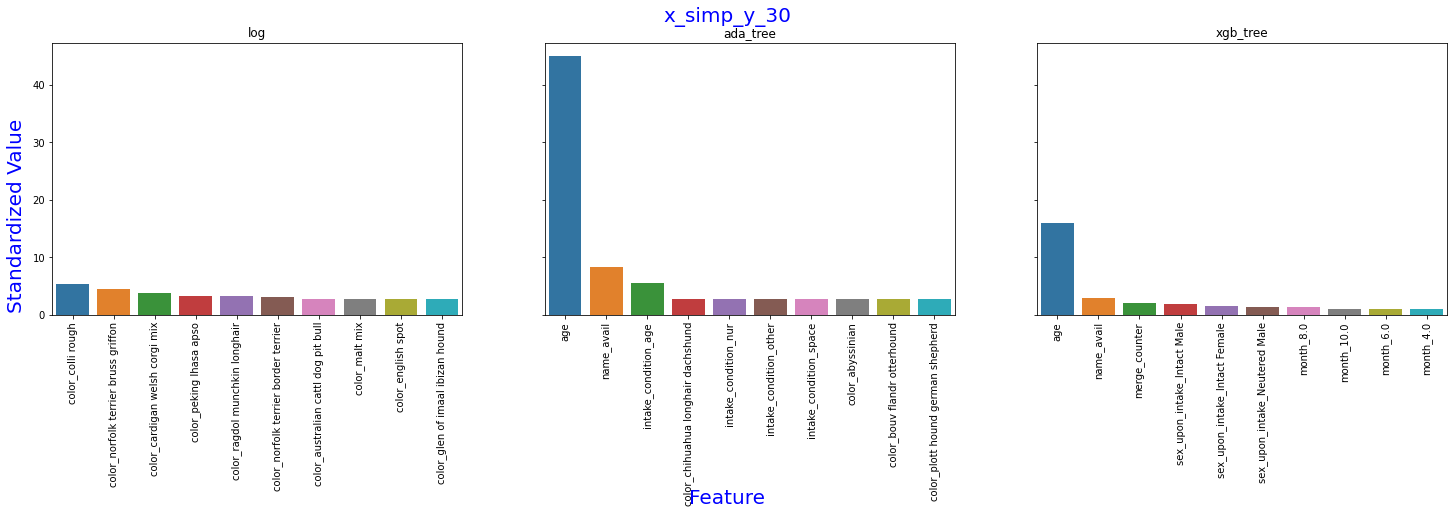

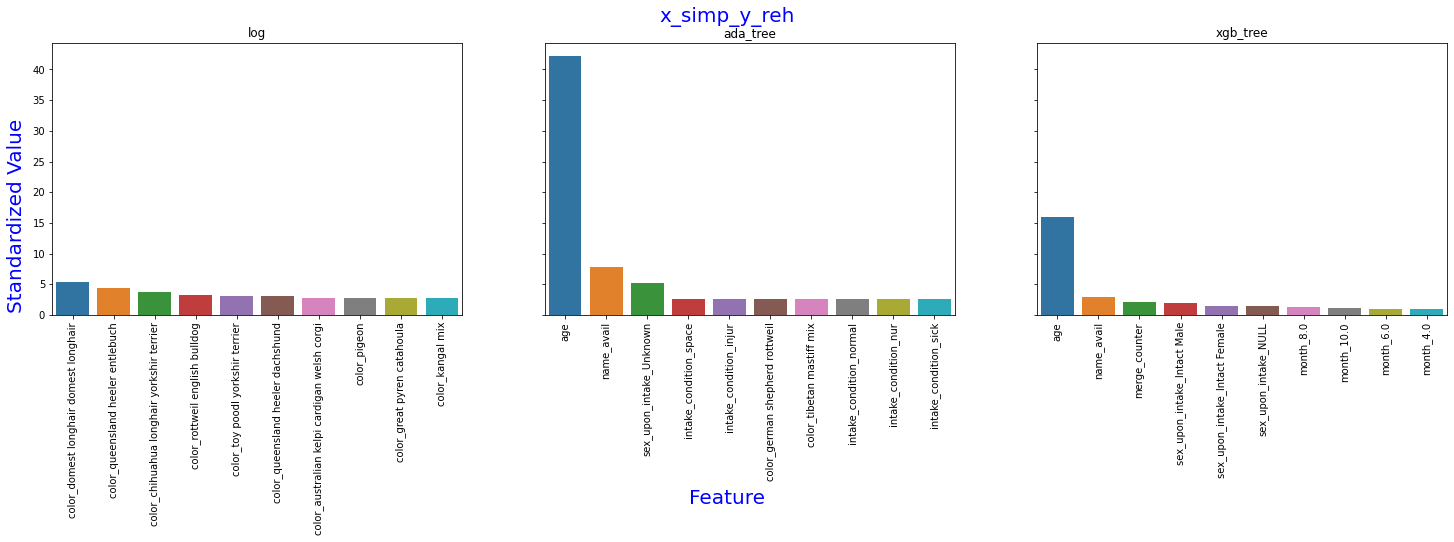

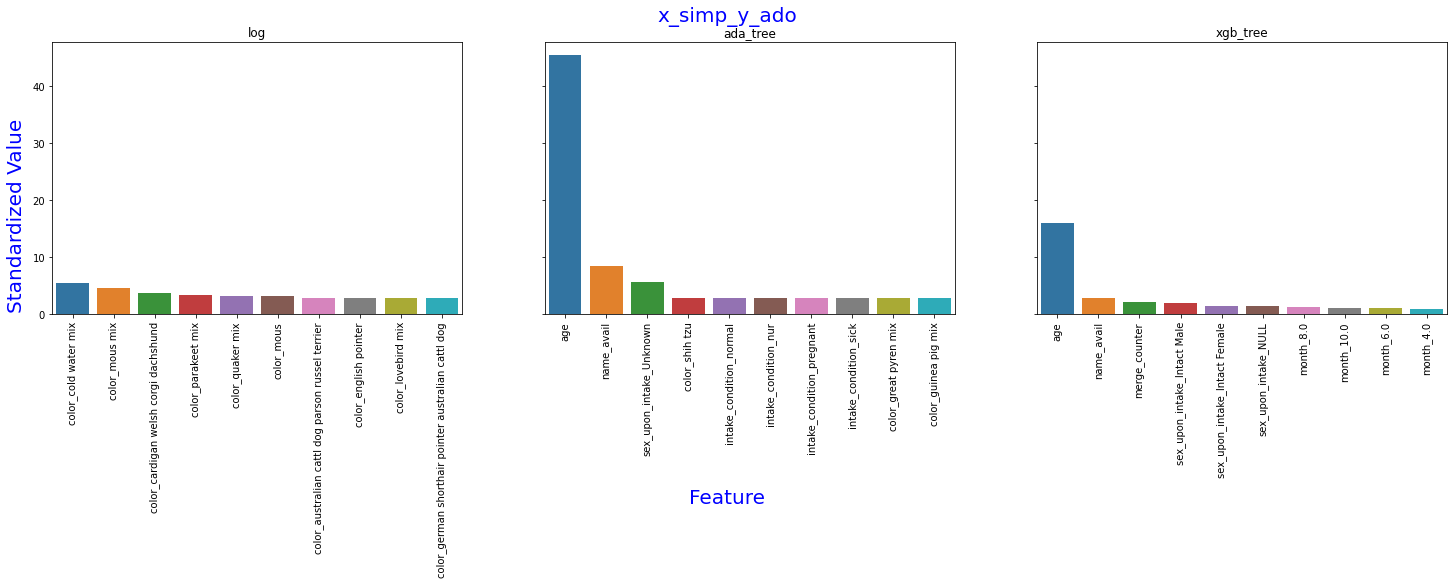

In [112]:

model_importances = {}
for p in range(len(name_dict)):
    for index_val, model_name in enumerate(fitted_dict[p]):
        try:
            model_importances[model_name] = model_importance(fitted_dict[p][model_name])
            model_importances[model_name]['scaled'] = (model_importances[model_name]['val']-model_importances[model_name]['val'].mean())/model_importances[model_name]['val'].std()
        except AttributeError as e:
            print(e)
            model_importances[model_name] = 0
        


    fig, axes = plt.subplots(1, 3, figsize=(25,5), sharey=True)
    ticker = 0
    for i,x in enumerate(model_importances):
        try:
            sns.barplot(ax=axes[ticker], x='feature', y='scaled', data=model_importances[x].head(10))
            axes[ticker].tick_params(axis='x', rotation=90)
            axes[ticker].set(xlabel=None, ylabel=None, title=x)
        except AttributeError:
            ticker -= 1
        finally:
            ticker +=1
    fig.suptitle(name_dict[p], color='blue', size = 20)
    fig.text(0.5, -0.4, 'Feature', ha='center', size=20, color='blue')
    fig.text(0.1, 0.4, 'Standardized Value', va='center', rotation='vertical', size=20, color='blue')
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=40)





### Fine-tuning Hyperparameter


Random Forest


In [ ]:
# gridsearch cv on random forest

# Parameter grid for GridSearch
param_grid = {'model__n_estimators': [150],  # , 50, 75, 100, 125, 150, 200, 250],
              'model__max_features': [.2, .5, 1.0, 'auto'],  # , 25, 30],
              # , 50, 75, 100, 125, 150, 200, 250],
              'model__max_depth': [3, 10, 100],
              'model__min_samples_split': [2, 5, 50]  # , 25, 30, 45, 50]
              }


grid_search = GridSearchCV(fitted_models['rfc_tree'],  # Base model
                           param_grid,  # Parameters to try
                           cv=5,  # Apply 5-fold cross validation
                           verbose=10,  # Print summary
                           )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)


In [ ]:
#This is what did best:
#model__max_depth=100, model__max_features=0.2, model__min_samples_split=2, model__n_estimators=150
best_rfc = create_model(x=X_train, y=y_train, feats=x, model = RandomForestClassifier(max_depth=100, max_features=0.2, min_samples_split=2, n_estimators=150), tree=1)

best_rfc.fit(X_train, y_train)
val_predictions = best_rfc.predict(X_val)
actual_predictions = best_rfc.predict(X_train)
print('Model performance on the train set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("val accuracy:", accuracy_score(y_val, val_predictions))
print("train accuracy:", accuracy_score(y_train, actual_predictions))

In [ ]:
#This is what did best:
#model__max_depth=100, model__max_features=0.2, model__min_samples_split=2, model__n_estimators=150
print(grid_search.best_params_)
print(grid_search.best_score_)
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)
val_predictions = classifier.predict(X_val)

print('Model performance on the train set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("val accuracy:", accuracy_score(y_val, val_predictions))


In [ ]:
fitted_models['xgb_tree'].

In [ ]:
parameters = {
    'model__max_depth': range(5, 9, 1),
    'model__n_estimators': range(100,200,20),
    'model__learning_rate': [0.3,0.2,0.1],
    'model__base_score': [0.6,0.65],
    'model__reg_lambda': [1.1,1.2]
}

grid_search = GridSearchCV(
    estimator=fitted_models['xgb_tree'],
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 5,
    verbose=10
)

grid_search.fit(X_train,y_train)

In [ ]:
#{'model__base_score': 0.6, 'model__learning_rate': 0.3, 'model__max_depth': 6, 'model__n_estimators': 100, 'model__reg_lambda': 1.1}
#Try 2: {'model__base_score': 0.6, 'model__learning_rate': 0.3, 'model__max_depth': 8, 'model__n_estimators': 180, 'model__reg_lambda': 1.1}

print(grid_search.best_params_)
print(grid_search.best_score_)
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)
val_predictions = classifier.predict(X_val)
print('Model performance on the train set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("val accuracy:", roc_auc_score(y_val, val_predictions))
actual_predictions = best_rfc.predict(X_train)
print("train accuracy:", roc_auc_score(y_train, actual_predictions))

In [ ]:
from sklearn.model_selection import PredefinedSplit

new_X_train = X_train.append(X_val)
new_Y_train = y_train.append(y_val)
fold = [-1]*X_train.shape[0] + [0]*X_val.shape[0]
train_indices = np.full((X_train.shape[0],), -1, dtype=int)
val_indices = np.full((X_val.shape[0],), 0, dtype=int)
test_fold = np.append(train_indices, val_indices)
ps = PredefinedSplit(test_fold)




In [ ]:
import matplotlib.pyplot as plt

xvals = [i for i in range(0, 10)]
yvals1 = [i**2 for i in range(0, 10)]
yvals2 = [i**3 for i in range(0, 10)]

f, ax = plt.subplots(1)
ax.plot(xvals, yvals1)
ax.plot(xvals, yvals2)